# **Assignment 5 - Parameter Identification**                    

ShivakumarSridhar                                                 (1234846225)

# **Servo Data Collection**

## Part 1: The Experiment

1. I flashed the ESP32 using the Arduino IDE and crafted a simple C++ program utilizing the ESP32Servo library to alternate the servo between 0 and 180 degrees every second.



```
#include <ESP32Servo.h>

Servo myServo;  // Create servo object

// Use Pin 14 to match your MicroPython code
int servoPin = 14;

void setup() {
  // Attach the servo to the pin
  myServo.attach(servoPin);
}

void loop() {
  // Move to 0 degrees
  myServo.write(0);
  delay(1000); // Wait for 1 second (1000 milliseconds)

  // Move to 180 degrees
  myServo.write(180);
  delay(1000); // Wait for 1 second
}
```



2. I then plugged in my ESP32 to a half-size breadboard and wired up my servo. I hung the end of
the servo off the edge of a desk and weighted it down so it wouldn’t move.


3. I wrapped a wire around my AA battery to rigidly attach it to the servo’s horn. I mounted the
battery so it was mounted symmetrically about the rotational center of the servo.


4. I weighed the battery

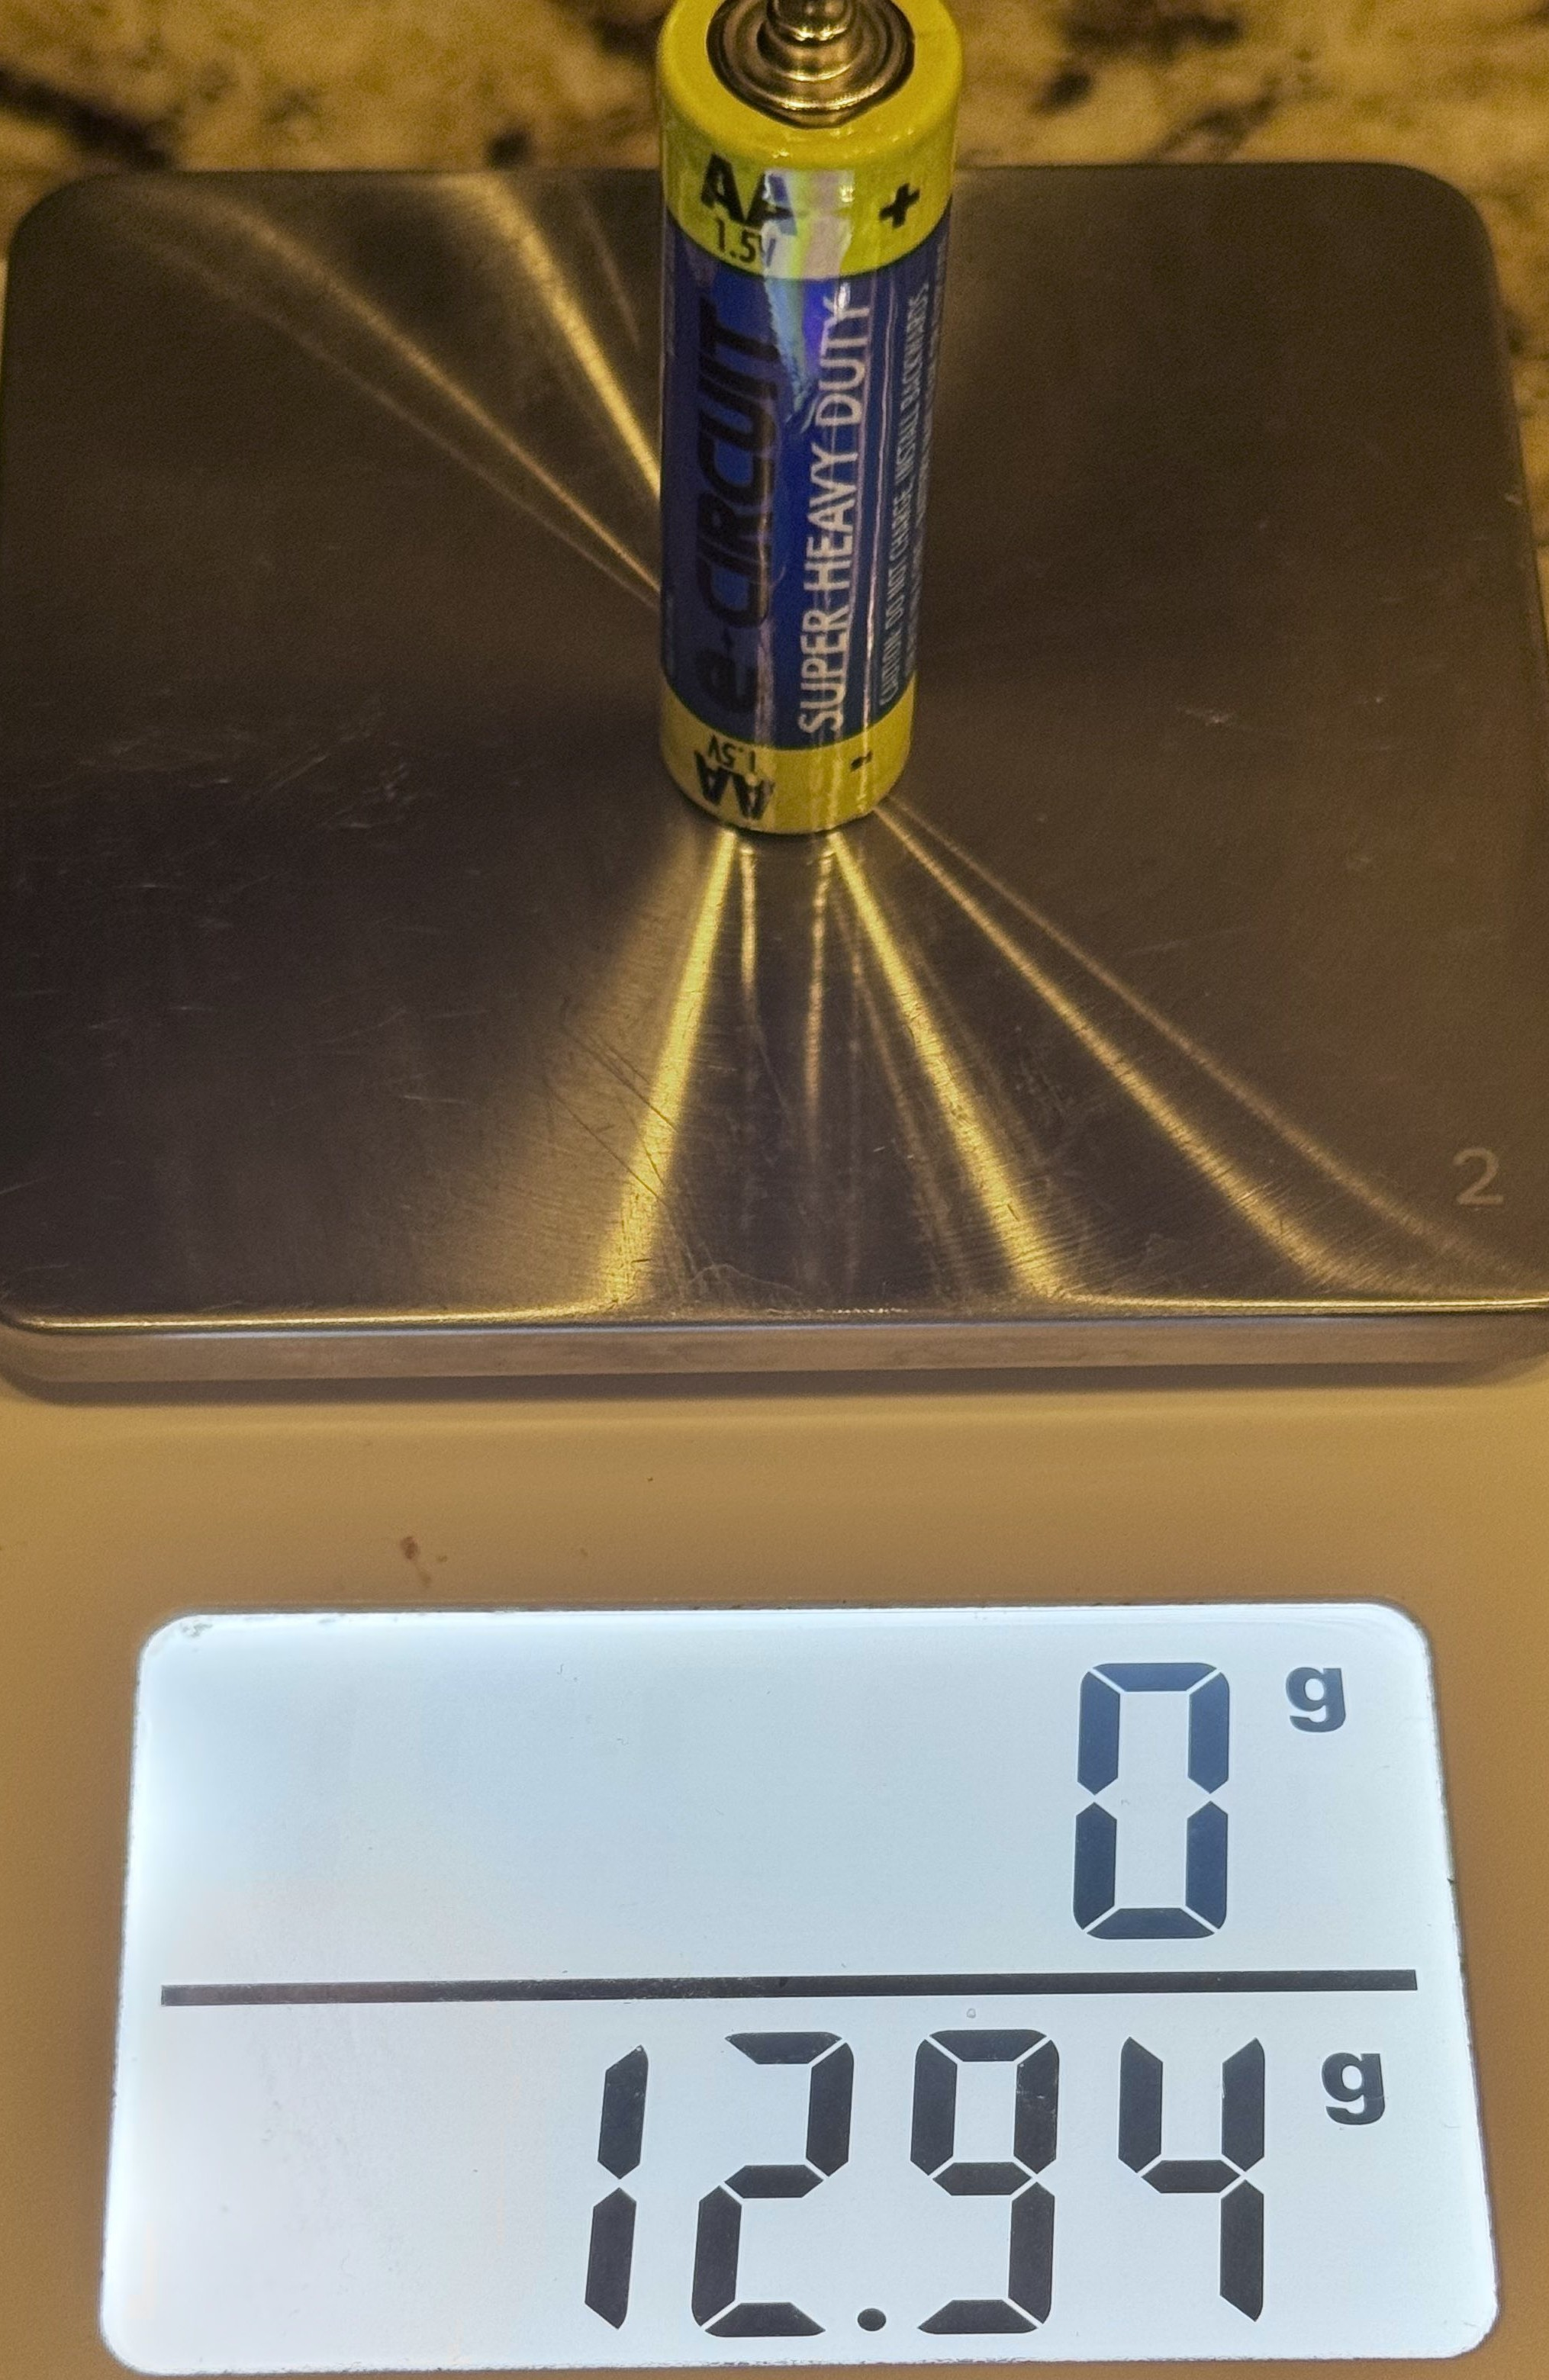

In [ ]:
from IPython.display import Image, display
display(Image("battery.jpg", width=300))

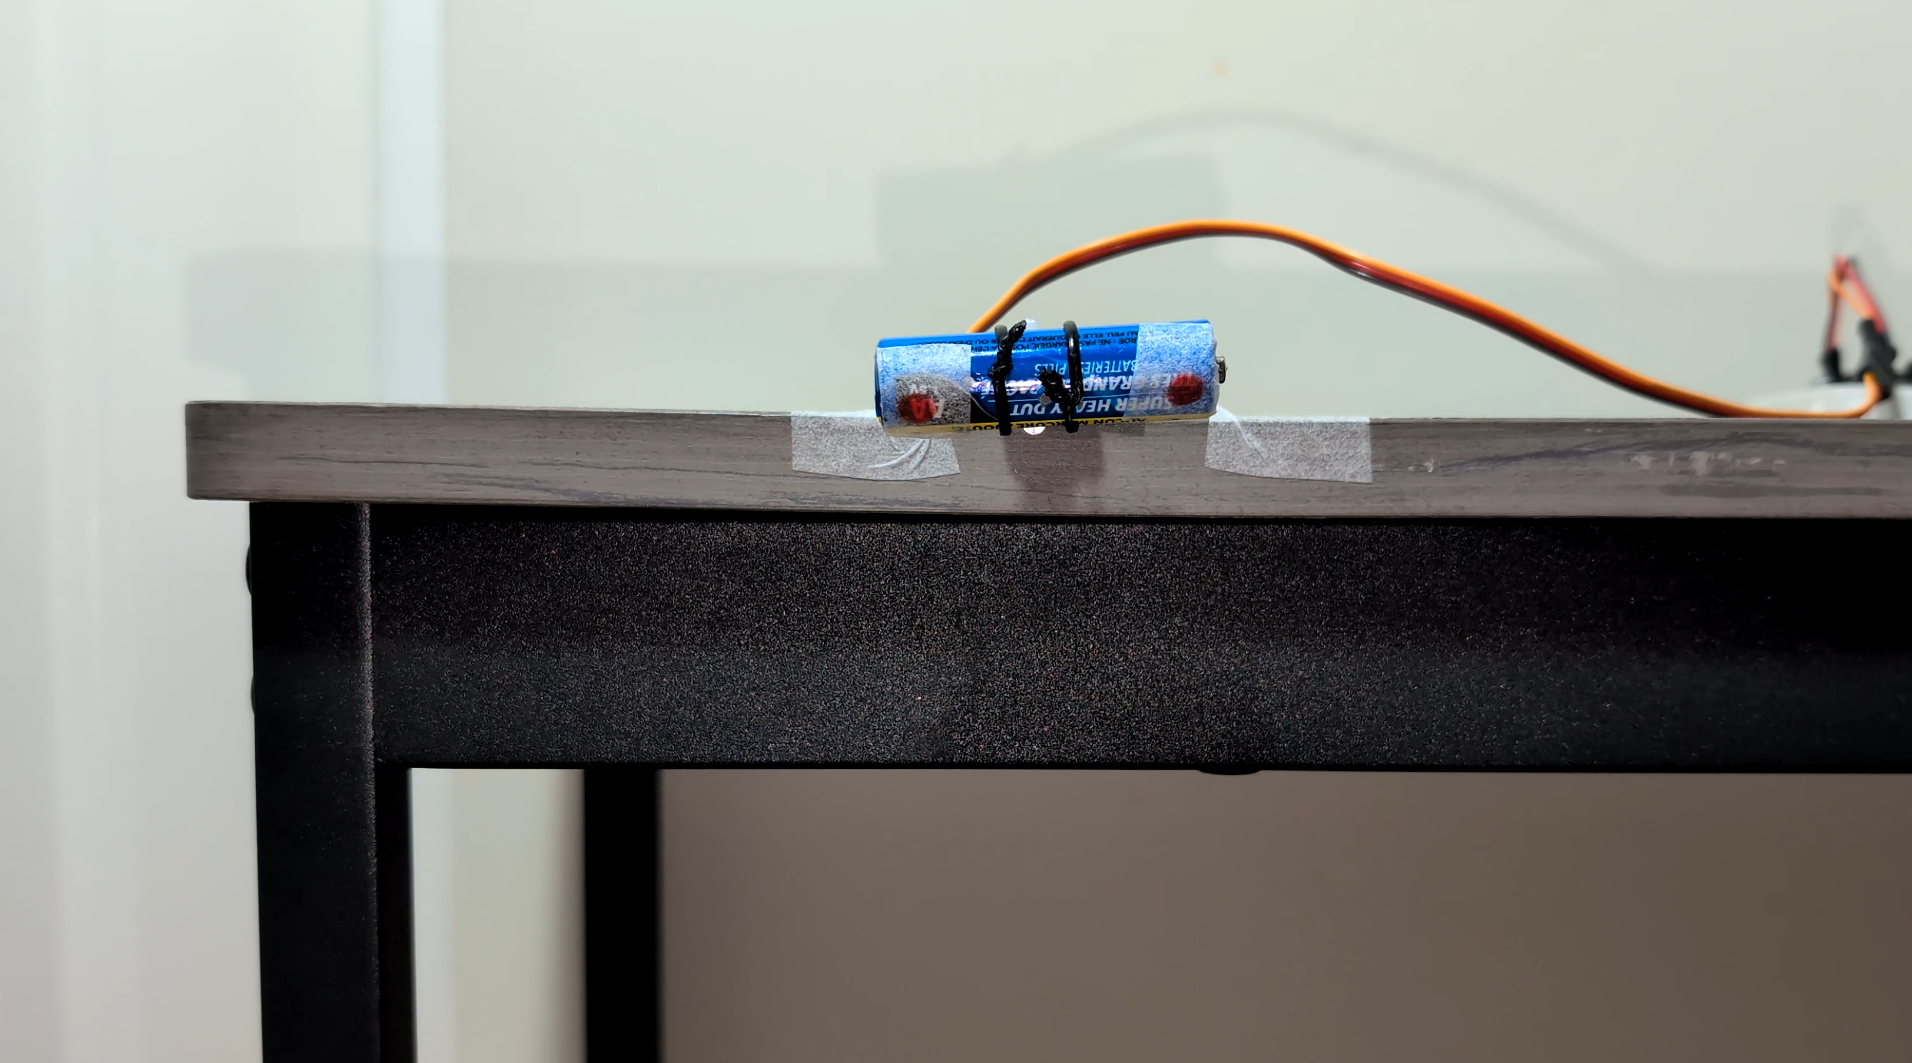

In [ ]:
from IPython.display import Image, display
display(Image("baresetup.png", width=800))

5. I used a tripod to hold my cell phone approximately 12 inches away from my scene. I made
sure my servo was in the center of my frame, that my camera was perpendicular to the plane
of my experiment.

6. I took several practice videos and checked them to ensure the camera didn’t move, the base of
the servo didn’t shake or move, and that my scene was well-lit and in focus.


## Part 2: Image Tracking

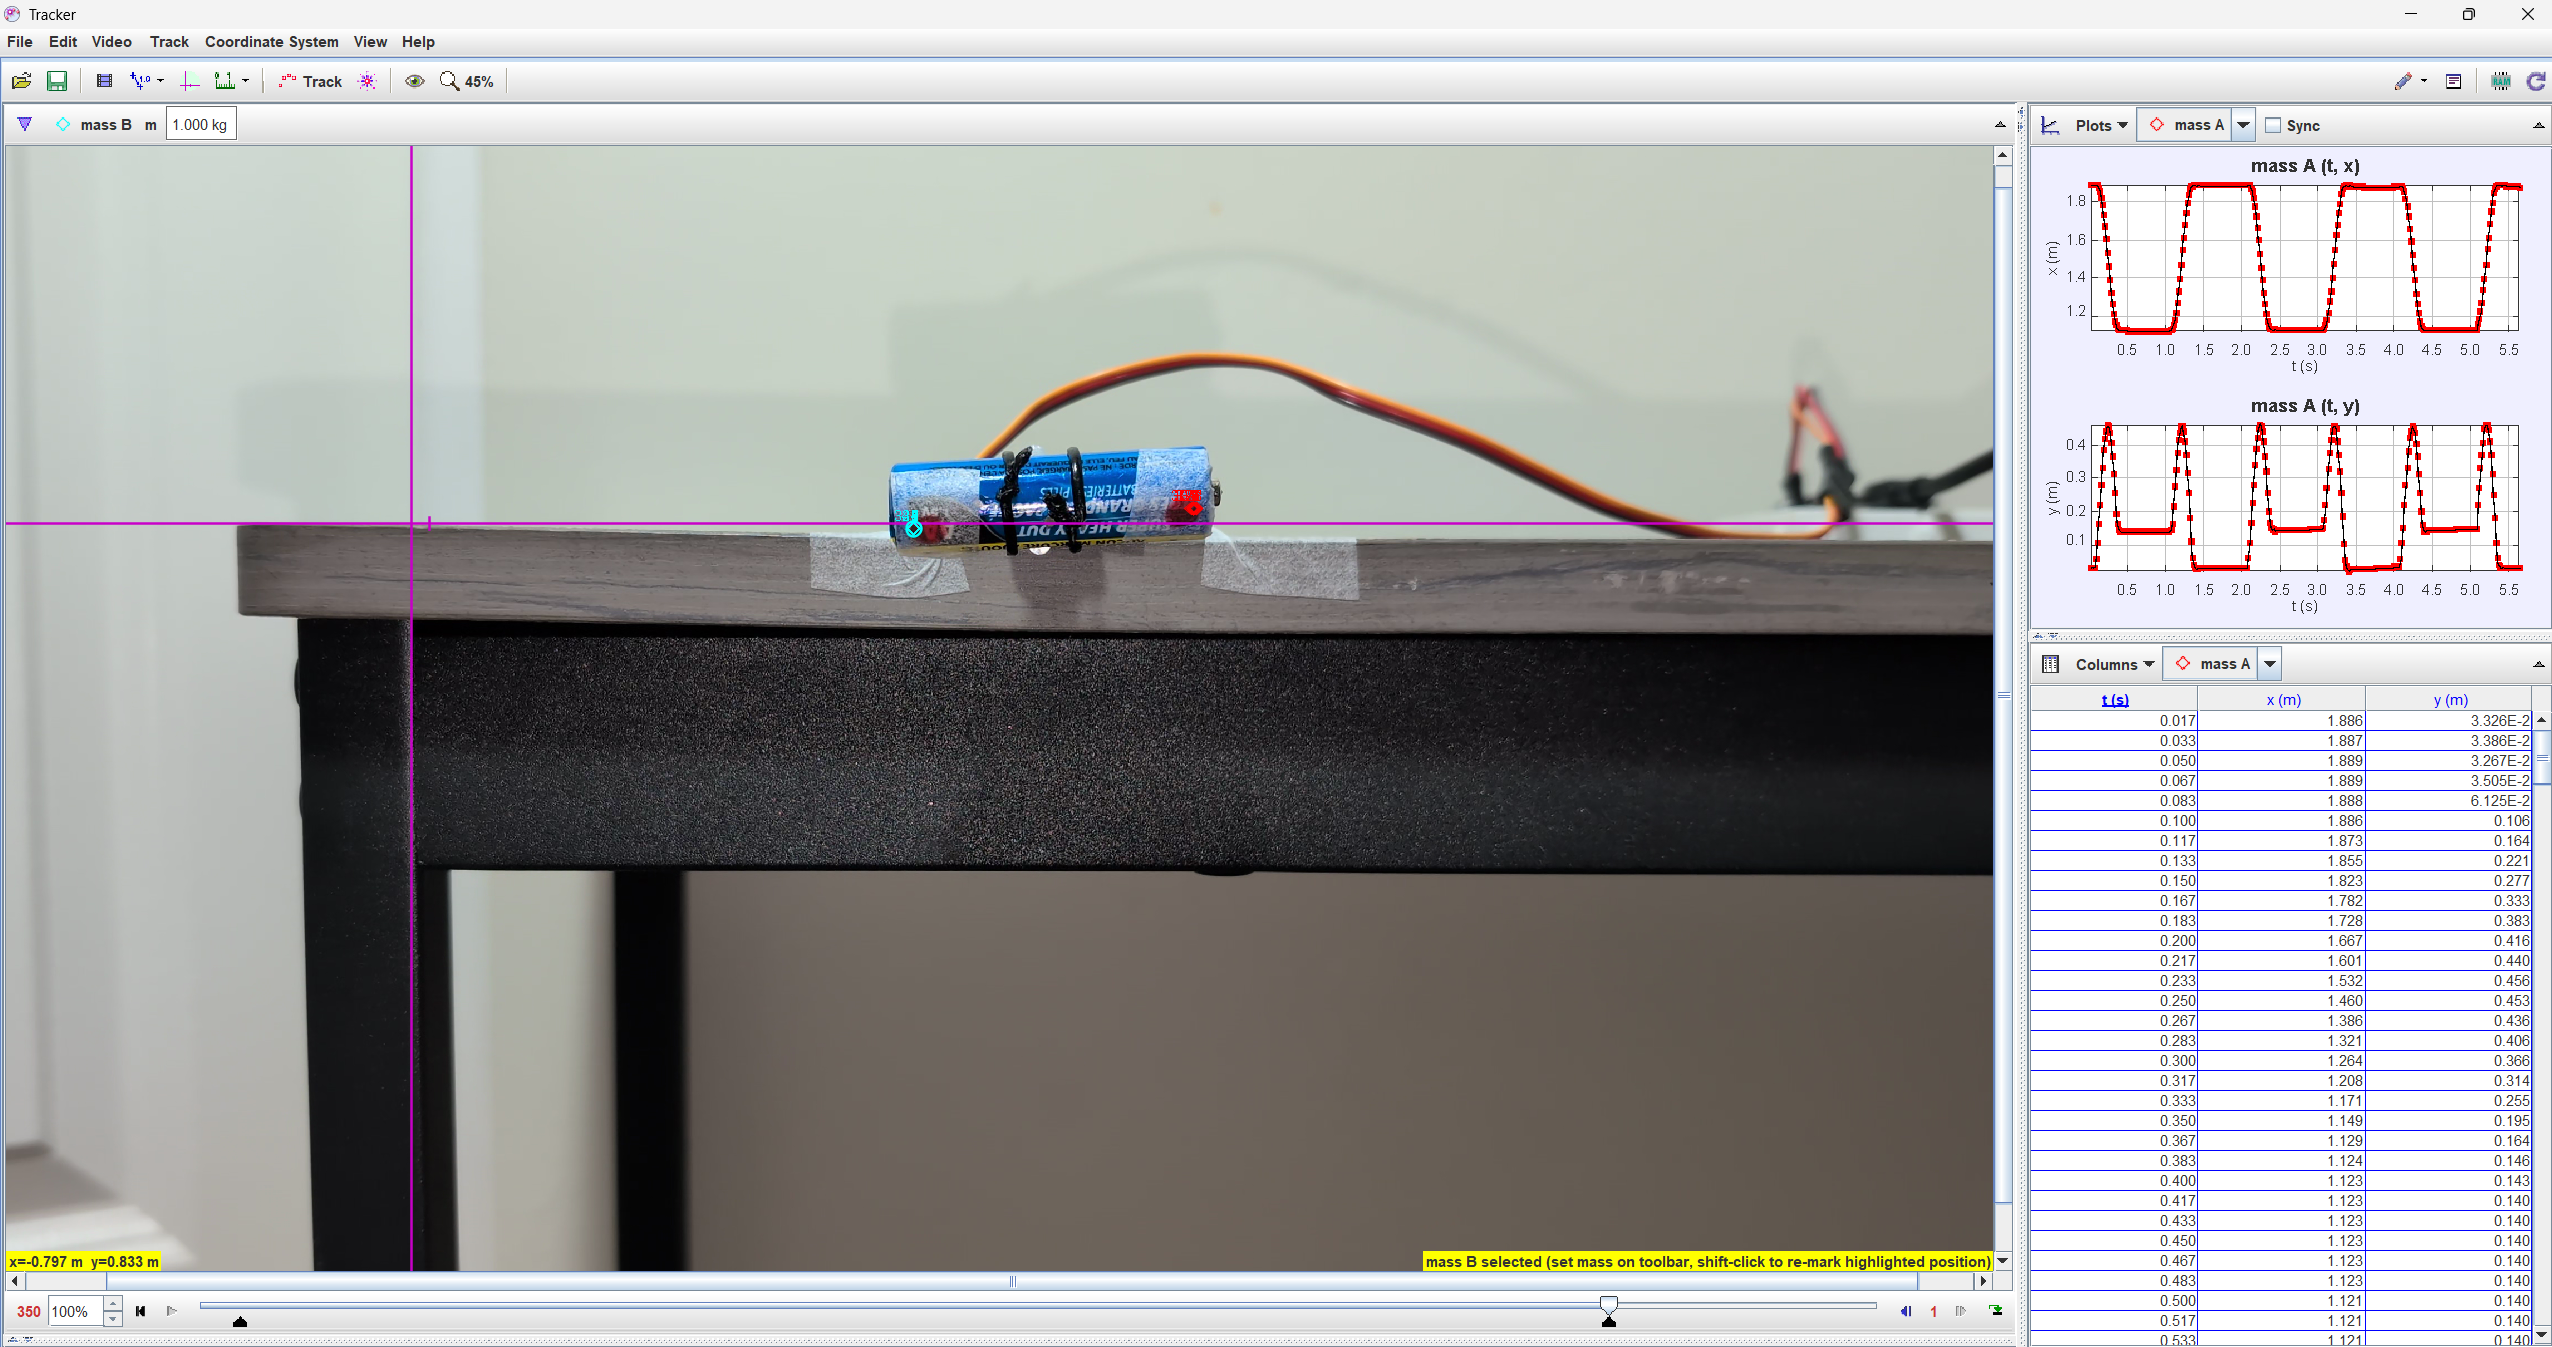

In [ ]:
from IPython.display import Image, display
display(Image("trackingsetup.png", width=800))



1.   I installed tracker on a Windows computer and imported my video. I identiȴed several high-contrast
points that remained visible even during the blurry bits when the servo was rotating.
2.    I used the edge of the desk as my x-axis reference line, to ensure the x-y coordinate system matched up with a planar model with gravity in the -y direction.

3.    I output the data as trackpoints.csv





## Part 3: Calculating the Data

First, let’s import some necessary packages in python

In [ ]:
import pandas
import scipy.signal as ss
import scipy.optimize as so
import numpy
import matplotlib.pyplot as plt
import math


Next, we import data collected by tracker and identify the useful columns

In [ ]:
data = pandas.read_csv('trackpoint25_1_2.csv')
data.columns
data.iloc[:10, :].head()

t     x       y   x.1    y.1
0  0.0000  1.88  0.0307  1.21 -0.014
1  0.0167  1.89  0.0334  1.21 -0.014
2  0.0333  1.88  0.0334  1.21 -0.014
3  0.0500  1.88  0.0334  1.21 -0.014
4  0.0666  1.88  0.0334  1.21 -0.014

Extract the time and position data of our markers


In [ ]:
t = data['t']

## Finding the center of rotation.


First, make a guess for the center of rotation by ȴnding the mean of all the x and y data of our ȴrst
point. This is rough but it should be close enough for an optimizer to do the rest


In [ ]:
xini = data['x'].mean()
yini = data['y'].mean()
ini = numpy.array([xini,yini])
print(ini)

[1.53905063 0.14464557]


Next, create a function that ȴnds the sum of squared radii given an x,y coordinate guess for the center
of rotation, across the two points tracked. By obtaining the distance from the guessed center to each
point over all the data, the true center should minimize the sum of all distances to all tracked points.


In [ ]:
def fun(guess):
  # break out guess into two variables, x0 and y0
  x0,y0 = guess
  # start with zero error
  error = 0
  # sum the squared length to point 1 over all time and add to error
  error += ((data['x']-x0)**2+(data['y']-y0)**2).sum()
  # sum the squared length to point 2 over all time and add to error
  error += ((data['x.1']-x0)**2+(data['y.1']-y0)**2).sum()
  # take the square root
  error = error**.5
  # return the error
  return error

The function, evaluated at the initial guess should provide a baseline error that can go lower still

In [ ]:
print(fun(ini))

8.867323472680075


Run the minimization and check the result


In [ ]:
result = so.minimize(fun,ini)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.632985164032121
        x: [ 1.515e+00  6.765e-02]
      nit: 4
      jac: [-1.073e-06 -3.934e-06]
 hess_inv: [[ 9.240e-01 -2.625e-01]
            [-2.625e-01  8.936e-02]]
     nfev: 21
     njev: 7

Compute the vectors from the origin to the two tracked points. This will e΍ectively shift the original
tracked points to move about the result of our optimization, the selected center of rotation in the video.

In [ ]:
v1 = numpy.array([data['x']-result.x[0],(data['y']-result.x[1])]).T
v2 = numpy.array([data['x.1']-result.x[0],(data['y.1']-result.x[1])]).T

Plot the vectors over time, along with a dot at the origin.

(np.float64(-0.4443639008556089),
 np.float64(0.41363609914439087),
 np.float64(-0.3437029614301713),
 np.float64(0.42739703856982875))

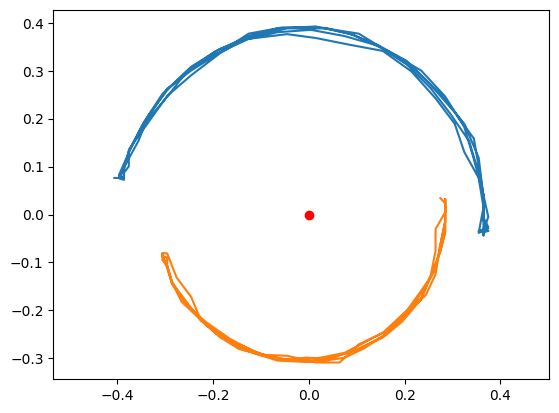

In [ ]:
plt.plot(v1[:,0],v1[:,1])
plt.plot(v2[:,0],v2[:,1])
plt.plot(0,0,'ro')
plt.axis('equal')

The angle of each vector can be computed by taking the arctan of the x and y components of vector 1
and 2. Plot the result.


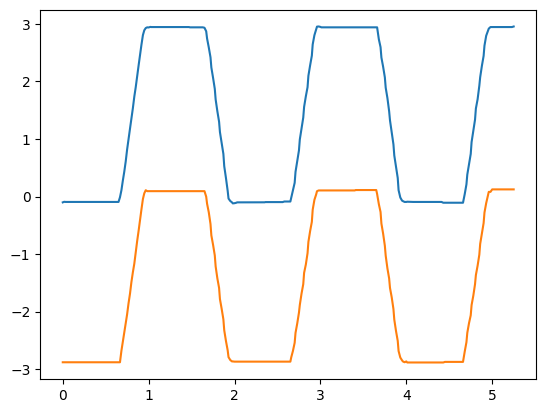

In [ ]:
theta_v1 = numpy.arctan2(v1[:,1],v1[:,0])
theta_v2 = numpy.arctan2(v2[:,1],v2[:,0])
plt.plot(t,theta_v1)
plt.plot(t,theta_v2)

We can further work with the data to “unwrap this value. Any value
that jumps more than (Pi) between individual timesteps by the arctan2 function can be interpreted to
actually be continuously increasing (or decreasing) past that value.

In [ ]:
import numpy

def unwrap(theta, period):
    # Create a holder for our new theta measurement, theta2, and seed it with the initial value
    theta2 = [theta[0]]

    # We need to compare our current theta measurement against the previous one
    last_theta = theta[0]

    # Create a holder for the offset (number of periods)
    mem = 0

    # Loop through theta starting at the 2nd data point (index 1)
    # We don't need 't' here, so we just iterate through theta directly
    for item in theta[1:]:
        # Compare our current theta against the last theta
        dt = (item - last_theta)

        # Check for big jumps (positive or negative)
        if dt > (period / 2):
            mem -= period
        if dt < (-period / 2):
            mem += period

        # Compute the corrected value and add to list
        theta2.append(item + mem)

        # Update last_theta for the next iteration
        last_theta = item

    # Reform as a numpy array and return
    return numpy.array(theta2)

now run the function on our two guesses for vector 1 and vector 2

In [ ]:
theta_v1_u = unwrap(theta_v1,2*math.pi)
theta_v2_u = unwrap(theta_v2,2*math.pi)

By subtracting the initial values for theta_1 and theta_2 we obtain two guesses for the same angle
value.


In [ ]:
theta_v1_u-=theta_v1_u.min()
theta_v2_u-=theta_v2_u.min()

Plot the corrected values


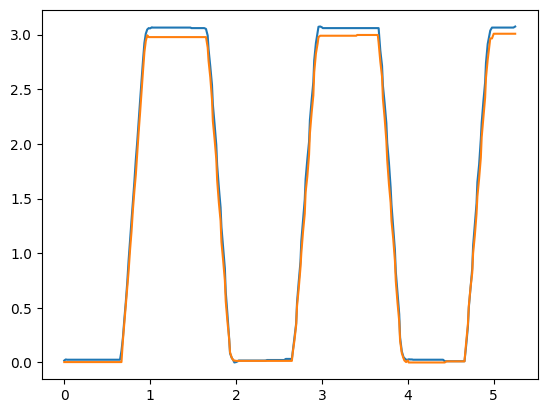

In [ ]:
plt.plot(t,theta_v1_u)
plt.plot(t,theta_v2_u)

Compute the average of these two samples. Adding even more points to this analysis would give us a
more accurate measurement of theta.

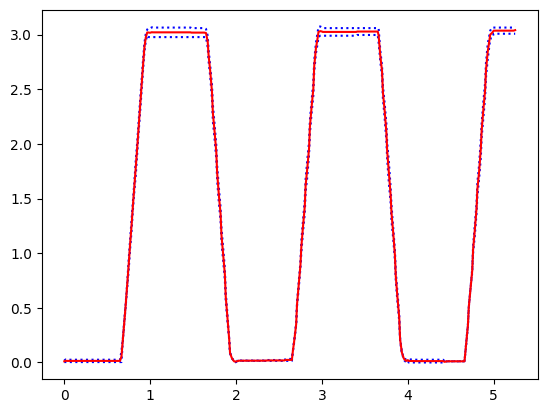

In [ ]:
theta_u = (theta_v1_u+theta_v2_u)/2
plt.plot(t,theta_v1_u,'b:')
plt.plot(t,theta_v2_u,'b:')
plt.plot(t,theta_u,'r-')


maximum value of our guessed value of theta?

In [ ]:
tMax = theta_u.max()
tMax*180/math.pi

np.float64(174.25678519714705)

## Part 4: Guessing the input signal


Reconstructing the step signal sent by the ESP32 and place it one time-step in front of any observed motion in the
frames.
First, we make a filter to only look at data values less than a second, just to zoom in on the first transition

In [ ]:
time_filter = t<1

In [ ]:
jj = theta_u[time_filter] > \
(theta_u[time_filter].max() - theta_u[time_filter].min())*.01 \
+ theta_u[time_filter].min()
t_0_kk = (t[time_filter][jj]).idxmin()
t_0 = t[t_0_kk]
t_0

np.float64(0.666)

In [ ]:
import numpy as np

# 1. Define a "Movement Threshold"
# (We assume movement starts when angle > 5% of the jump)
min_val = np.min(theta_v1_u)
max_val = np.max(theta_v1_u)
threshold = min_val + 0.05 * (max_val - min_val)

# 2. Find all indices where the angle is GREATER than the threshold
movement_indices = np.where(theta_v1_u > threshold)[0]

# 3. Pick the FIRST index (The start moment)
if len(movement_indices) > 0:
    start_index = movement_indices[0]

    # 4. Get the time at that index
    # (Note: Use 't' or 't_clean' depending on what you named your cleaned time variable)
    t_0 = t[start_index]

    print(f"Calculated New t_0: {t_0}")
else:
    print("Error: No movement detected! Check your data.")

Calculated New t_0: 0.683


We then plot the moment motion starts on top of the adjusted theta values:


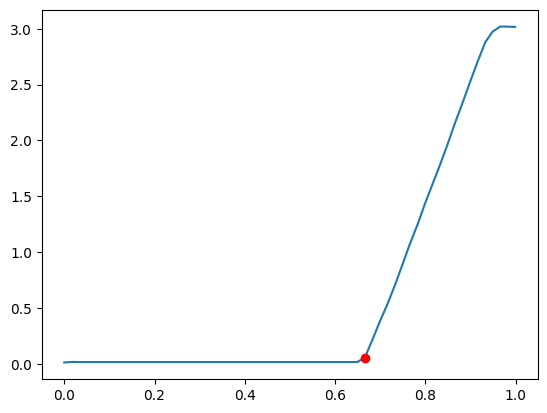

In [ ]:
plt.plot(t[time_filter],theta_u[time_filter])
plt.plot(t[t_0_kk],theta_u[t_0_kk],'ro')

This means the signal must have been sent at least one time-step before this. Maybe more, but the
best-case scenario for lag would be one frame of video.


Lets create a function that can generate a step function with the following parameters

A : amplitude
f : frequency
w : width (as a fraction of the full time step) of the positive portion of the square wave
b : y- offset


In [ ]:
#A = math.pi
A = tMax
f = .5
w = .5
b = 0

def square(t,A,f,w,b,t_0):
    y = (t-t_0)*f
    y = y%1
    y = (y<w)*1
    y = A*y +b
    return y

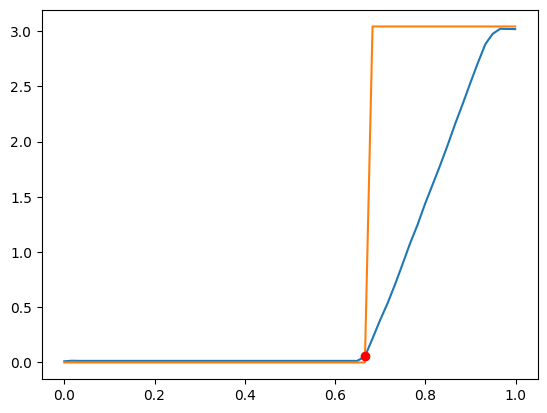

In [ ]:
y = square(t,A,f,w,b,t_0)
plt.plot(t[time_filter],theta_u[time_filter])
plt.plot(t[time_filter],y[time_filter])
plt.plot(t[t_0_kk],theta_u[t_0_kk],'ro')

Now lets check our results over all the collected data

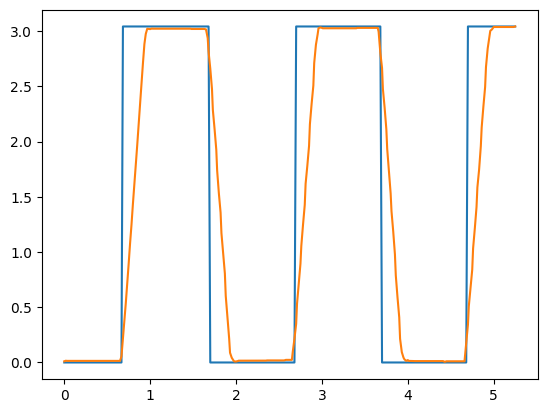

In [ ]:
plt.plot(t,y)
plt.plot(t,theta_u)

it looks good! Now let’s save some of our work for use in other code


In [ ]:
data = {}
data['A'] = A
data['f'] = f
data['b'] = b
data['w'] = w
data['t'] = t
data['t_0'] = t_0
data['theta_u'] = theta_u
import yaml
with open('servo_data_collection.yml','w') as f:
  yaml.dump(data,f)


# Servo Data Fitting

##Part 5: MuJoCo-based model


In [ ]:
# 1. Install missing libraries (Run this once)
!pip install mujoco mediapy

import os
os.environ['MUJOCO_GL'] = 'egl'

# 2. Import the libraries
import matplotlib.pyplot as plt
import numpy as np  # Standard convention is 'np'
import math
import yaml
import mujoco
import mediapy as media

print("All libraries imported successfully!")


All libraries imported successfully!


In [ ]:
def square(t,A,f,w,b,t_0):
    y = (t-t_0)*f
    y = y%1
    y = (y<w)*1
    y = A*y +b
    return y

# Motor Modeling

In [ ]:
Vnom = 6
G = 55.5
t_stall = 15/100/G
i_stall = .6
R = Vnom/i_stall
i_nl = .2
w_nl = .66*1000*math.pi/180*G
kt = t_stall/ i_stall
kv= Vnom/w_nl
ke = kt
b = kt*i_nl/w_nl
ts = 1e-4

I load the sanitized experimental data saved from the last article.

In [ ]:
with open('servo_data_collection.yml') as f:
    servo_data = yaml.load(f,Loader=yaml.Loader)


I convert it to a numpy array and check the shape

In [ ]:
t_data = numpy.array(servo_data['t'])
t_data.shape

(316,)

In [ ]:
dt_data = (t_data[-1]-t_data[0])/len(t_data)

convert the theta data to a compatible numpy array and check the shape. This will need to match
mujoco’s simulated data

In [ ]:
q_data = numpy.array([servo_data['theta_u']]).T
q_data.shape

(316, 1)

define the desired control signal (for plotting purposes). You will see I redefine this inside the controller function.


In [ ]:
desired = square(t_data,A=servo_data['A'],
f = servo_data['f'],w=servo_data['w'],
b=servo_data['b'],t_0=servo_data['t_0'])


xml template and format, supplying the time constant from above variables. This consists
of the following decisions:


my body consists of a cylinder whose size and mass matches the battery’s dimensions. It is centered around a revolute joint in the x axis.
• There is no information given about the motor’s own inertia, so I am going to ignore its e΍ect and
assume that the battery’s inertia dominates the motion. In class, we talk about the magniȴcation
of inertia through gearheads, but we will ignore it here.
• I added a small cylinder on one side just for visualizing the battery better.
• I include one actuator of type motor, located at joint_1. This will be controlled using a controller
callback function I deȴne later.

In [ ]:
render_width = 800
render_height = 600

# 2. The XML Template (Make sure to copy the ending quotes!)
xml_template = f"""
<mujoco>
    <visual>
        <global offwidth="{render_width}" offheight="{render_height}" />
    </visual>

    <option timestep="{ts}"/>

    <worldbody>
        <light name="top" pos="0 0 10"/>

        <body name="body_1" pos="0 0 0">
            <joint name="joint_1" type="hinge" axis="1 0 0" pos="0 0 0"/>
            <geom type="cylinder" size=".00725 .024" pos="0 0 0" rgba="0 1 1 1" mass=".016"/>
            <geom type="cylinder" size=".0025 .0025" pos="0 0 .024" rgba="0 1 1 1" mass="0"/>
        </body>
    </worldbody>

    <actuator>
        <motor name="motor_1" joint="joint_1"/>
    </actuator>
</mujoco>
"""

print("MuJoCo XML template created successfully.")

MuJoCo XML template created successfully.


I format my template with my one variable, ts , to create my xml string


In [ ]:
xml = xml_template.format(ts = ts, render_width = render_width, render_height = render_width)

I create my model, data and renderer and a function that runs the model, changing the kp and b values
as needed.

In [ ]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model,width=render_width,height=render_height)
duration = t_data[-1] # (seconds)
framerate = 30 # (Hz)
data_rate = 1/dt_data
print(duration,data_rate)

5.25 60.1904761904762


Next create a function that generates a controller callback function and runs the simulation, returning
the time vector and position vector for joint_1

In [ ]:
def run_sim(kp, b_act, render=False, video_filename=None):
    # Define the V_supply used in the experiment
    V_supply = 5

    def mycontroller1(model, data):
        '''
        This function computes the torque to be applied to joint 1
        as a function of the time-based commands sent to the servo,
        and its current position and velocity.
        '''
        w = data.qvel[0]
        actual = data.qpos[0]
        t = data.time
        desired = square(t, A=servo_data['A'], f=servo_data['f'],
                         w=servo_data['w'], b=servo_data['b'],
                         t_0=servo_data['t_0'])
        error = desired - actual
        V = kp * error
        if V > V_supply: V = V_supply
        if V < -V_supply: V = -V_supply
        torque = (kt * (V - (ke) * w * G) / R - b_act * w * G) * G
        data.ctrl = [torque]
        return

    try:
        mujoco.set_mjcb_control(mycontroller1)
        q = []
        w = []
        t = []
        frames = []
        mujoco.mj_resetData(model, data)
        while data.time < duration:
            # print(data.time)
            mujoco.mj_step(model, data)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data)
                pixels = renderer.render()
                frames.append(pixels)

            if len(t) < data.time * data_rate: # print(data.time)
                q.append(data.qpos.copy())
                w.append(data.qvel.copy())
                t.append(data.time)

        if render:
            if video_filename is not None:
                media.write_video(video_filename, frames, fps=framerate)

        mujoco.set_mjcb_control(None)
        t = numpy.array(t)
        q = numpy.array(q)
        q = q[:len(q_data)]

    except Exception as ex:
        mujoco.set_mjcb_control(None)
        raise

    if render:
        return t, q, frames
    else:
        return t, q

Run the model and output the time / joint values

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

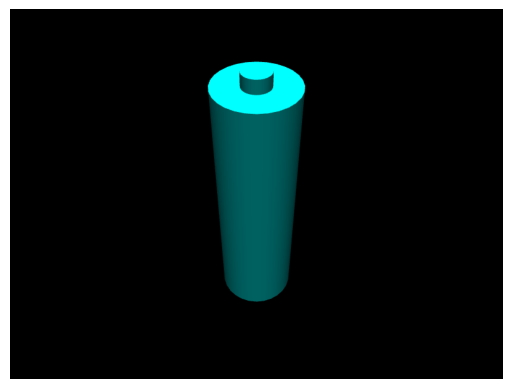

In [ ]:
t,q,frames = run_sim(kp = 15,b_act = b,render=True,video_filename='output1.mp4')
plt.imshow(frames[0])
plt.axis('off')

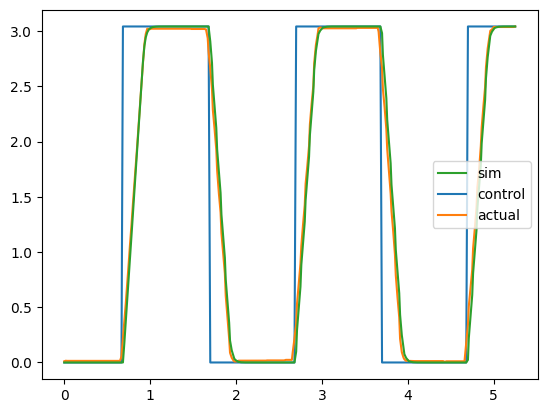

In [ ]:
a2 = plt.plot(t_data,desired)
a3 = plt.plot(t_data,q_data)
a1 = plt.plot(t_data,q)
plt.legend(a1+a2+a3,['sim','control','actual'])
plt.show()

## Testing out for different Kp Values

In [ ]:
t,q1 = run_sim(kp = 2,b_act = b,render=False)
t,q2 = run_sim(kp = 4,b_act = b,render=False)
t,q3 = run_sim(kp = 20,b_act = b,render=False)

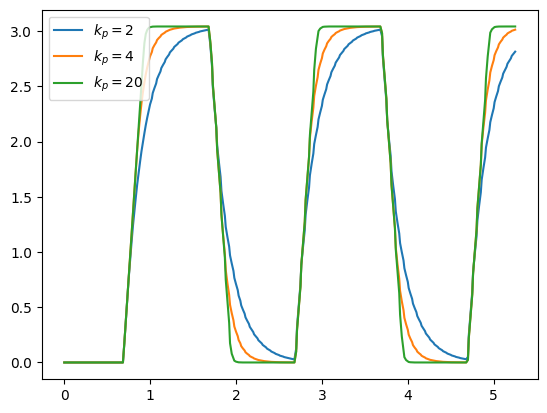

In [ ]:
a1 = plt.plot(t_data,q1)
a2 = plt.plot(t_data,q2)
a3 = plt.plot(t_data,q3)
plt.legend(a1+a2+a3,['$k_p=2$','$k_p=4$','$k_p=20$'])
plt.show()

## Observing the change in damping value which impacts the slope

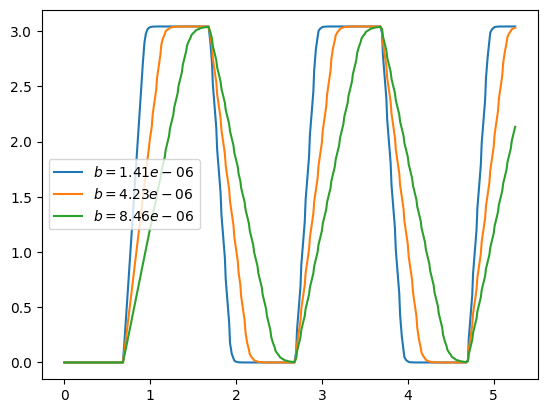

In [ ]:
t,q1 = run_sim(kp = 20,b_act = b,render=False)
t,q2 = run_sim(kp = 20,b_act = b*3,render=False)
t,q3 = run_sim(kp = 20,b_act = b*6,render=False)
a1 = plt.plot(t_data,q1)
a2 = plt.plot(t_data,q2)
a3 = plt.plot(t_data,q3)
plt.legend(a1+a2+a3,['$b={b:1.2e}$'.format(b=b),
'$b={b:1.2e}$'.format(b=b*3),
'$b={b:1.2e}$'.format(b=b*6)])
plt.show()

## Parameter Identification

Findind the best values for Kp and b. I import scipy.optimize and deȴne a function that will be
called by the minimize function. It runs the simulation and compares the simulation data against the
experimental data, ȴnds the error, and returns the sum of squared error over time.


In [ ]:
import scipy.optimize as so
def fun(vars):
    k,b = vars
    t,q = run_sim(k,b)
    error = q-q_data
    error = error**2
    error = error.sum()
    error = error**.5
    print(k,b,error)
    return error

Calculating the error with the inital guess

In [ ]:
ini = [15,b]
fun(ini)

15 1.4091678782734167e-06 1.7096900061567128


np.float64(1.7096900061567128)

In [ ]:
results = so.minimize(fun,x0=ini,method='nelder-mead',bounds = ((1,100),(b*.1,b*10)),
options={'xatol':1e-2,'fatol':1e-2})

15.0 1.4091678782734167e-06 1.7096900061567128
15.75 1.4091678782734167e-06 1.7070580518816834
15.0 1.4796262721870876e-06 1.901711206270756
15.75 1.3387094843597458e-06 1.5428128648755186
16.125 1.2682510904460747e-06 1.4171078527807803
16.875 1.2682510904460745e-06 1.417036493062932
17.8125 1.1977926965324034e-06 1.346836157452545
18.1875 1.0568759087050614e-06 1.398997615150432
19.875 9.864175147913903e-07 1.5259188444607923
17.0625 1.1977926965324036e-06 1.34548398482893
16.6875 1.3387094843597454e-06 1.541226372071262
17.8125 1.1273343026187325e-06 1.339318757110398
17.0625 1.127334302618733e-06 1.3366527356122144
16.6875 1.0921051056618977e-06 1.355086189352115
17.8125 1.0568759087050618e-06 1.3970524812031953
17.25 1.1625634995755681e-06 1.3333451577739248
16.5 1.1625634995755686e-06 1.331316066101089
15.84375 1.1801780980539866e-06 1.3344650718157565
16.6875 1.1977926965324038e-06 1.3448286834321095
16.96875 1.1449489010971505e-06 1.3323676161856375
16.21875 1.144948901097151e-

Check the final error

In [ ]:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3123013303428182
             x: [ 1.017e+01  1.119e-06]
           nit: 33
          nfev: 65
 final_simplex: (array([[ 1.017e+01,  1.119e-06],
                       [ 1.016e+01,  1.119e-06],
                       [ 1.016e+01,  1.119e-06]]), array([ 1.312e+00,  1.312e+00,  1.312e+00]))

Now run my simulation with the results of the optimization


(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

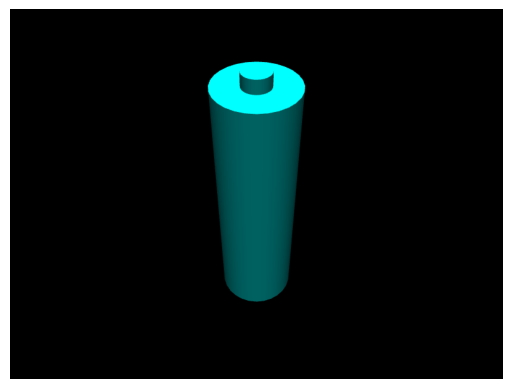

In [ ]:
kp_act, b_act =results.x
t,q,frames = run_sim(kp_act,b_act,render=True,video_filename='output.mp4')
plt.imshow(frames[0])
plt.axis('off')

Plot the results

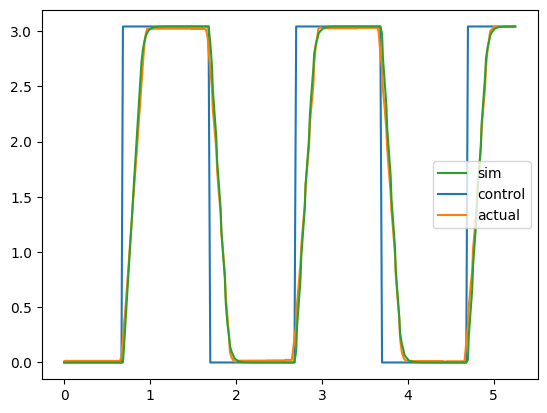

In [ ]:
a2 = plt.plot(t_data,desired)
a3 = plt.plot(t_data,q_data)
a1 = plt.plot(t_data,q)
plt.legend(a1+a2+a3,['sim','control','actual'])
plt.show()

## Back Calculating Other Parameters

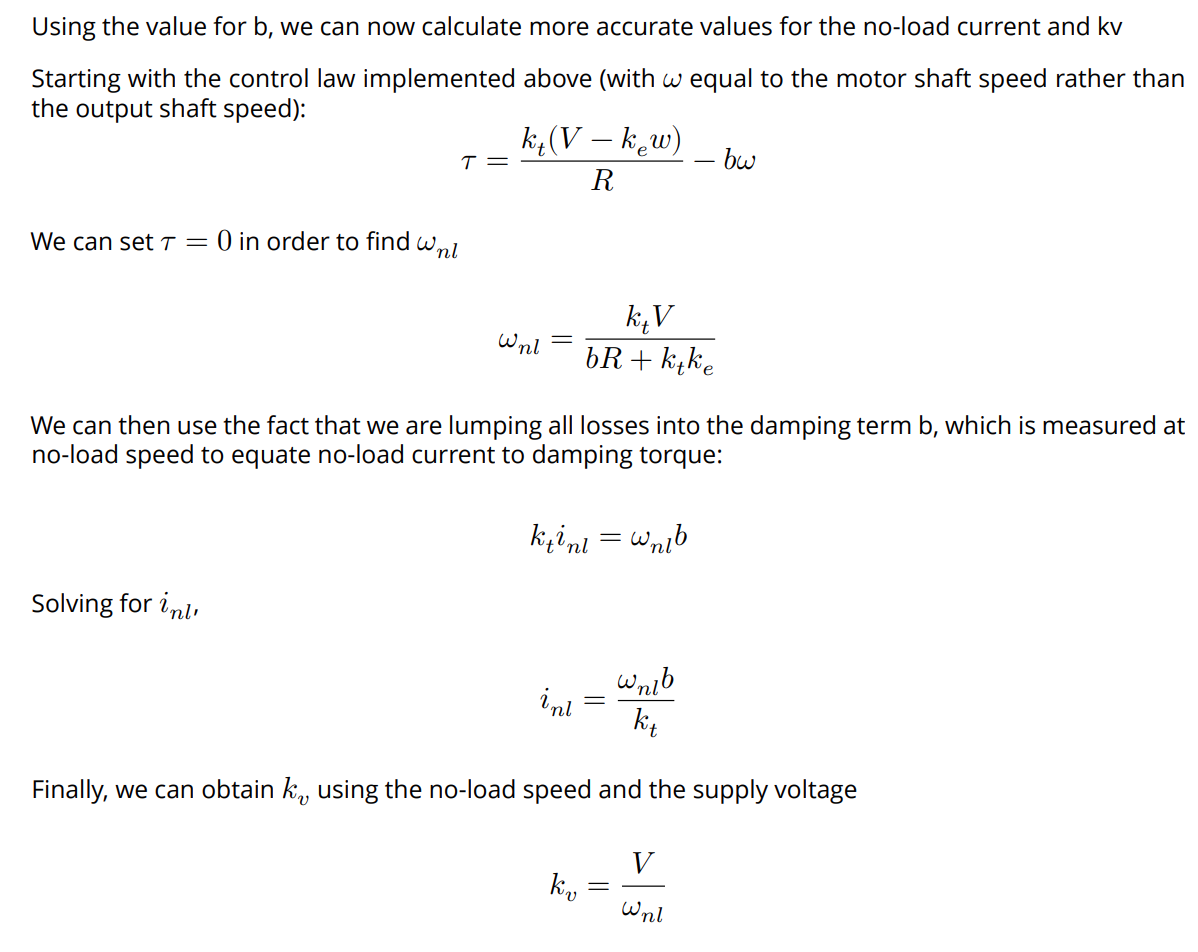

In [ ]:
from IPython.display import Image, display
display(Image("backparameters.png", width=800))

In [ ]:
V_supply = 5
w_nl_updated = kt*V_supply/(b_act*R +kt*ke)
i_nl_updated = w_nl_updated*b_act/kt
kv_updated = V_supply/w_nl_updated
print('w_nl: ',w_nl,'w_nl(updated): ',w_nl_updated)
print('i_nl: ',i_nl,'i_nl(updated): ',i_nl_updated)
print('k_v: ',kv,'k_v(updated): ',kv_updated)

w_nl:  639.3141050055228 w_nl(updated):  715.3381076168303
i_nl:  0.2 i_nl(updated):  0.17777562719962592
k_v:  0.009385058069300956 k_v(updated):  0.006989701718335188


# Conclusion

In this experiment, system identification was performed to determine the precise electromechanical parameters of the servo motor. By minimizing the error between the theoretical model and the experimental step-response data, we refined the motor constants to reflect physical reality. The results indicate that the actual motor is significantly faster and more efficient than the initial estimates. Specifically, the no-load speed (w_nl) increased by roughly 12% (from 639 to 715 rad/s), while the no-load current (i_nl) decreased from 0.20 A to 0.178 A, suggesting lower internal friction. This performance boost is mathematically consistent with the observed decrease in the Back-EMF constant (k_v) from 0.0094 to 0.0070 V/(rad/s), as a lower k_v directly enables higher rotational velocities for a given voltage. The final tuned model demonstrates a high degree of accuracy, with the simulation plot effectively merging with the experimental dataset.

# 6.5 Discussion

**6.5.1  What could you have done better in your experiment design and setup?**

Using a camera with a higher frame rate (e.g., 120 fps) would have captured more data points during the rapid rise time, which would have significantly reduced the noise in the acceleration calculations

We could have independently verified the Back-EMF constant (k_v) by driving the motor shaft at a known speed with a drill and measuring the generated voltage using an oscilloscope or multimeter, rather than relying solely on the simulation fit

**6.5.2 Discuss your rationale for the model you selected. Describe any assumptions or simpliȴcaitons
this model makes. Include external references used in selecting or understanding your model.**

We selected a standard linear DC motor model because it effectively captures the dominant electromechanical dynamics—specifically the interaction between Back-EMF, torque, and inertia—needed to predict the system's step response. A key simplification was modeling the battery load as a point mass ($J=mr^2$) and friction as purely viscous ($b\omega$), which ignores the distributed mass of the servo arm and non-linear static friction (stiction). Additionally, the model neglects electrical inductance ($L$), assuming the electrical time constant is significantly faster than the mechanical response, a standard approximation in electromechanical system dynamics [1]. This approach balances physical accuracy with computational efficiency, allowing for robust parameter identification without the complexity of modeling magnetic saturation or gear backlash.

**6.2.3 Justify the method you selected (least squares, nonlinear least squares, scipy.optimize.minimize(),
Evolutionary algorithm, etc. ) for fitting experimental data to the model, as well as the specific
algorithm used.**


To fit the experimental data to our model, we utilized a nonlinear least squares optimization method implemented through Python's scipy.optimize.minimize() function, specifically using the Nelder-Mead algorithm. We defined the 'cost function' as the sum of squared errors (SSE) between the experimental angle array and the simulation output, which penalizes large deviations to ensure a tight fit. This numerical approach was necessary because the system model contains non-linearities, such as the voltage saturation limit ($\pm 5$V), which make standard algebraic regression impossible. The Nelder-Mead algorithm was specifically chosen because it is a direct-search method that does not require calculating derivatives (gradients), allowing it to robustly optimize the parameters ($R, k_t, b$) even with the discontinuities present in the control logic.

**6.2.4 How well does your data fit the model you selected? Provide a numerical value as well as a
qualitative analysis, using your figure to explain.**


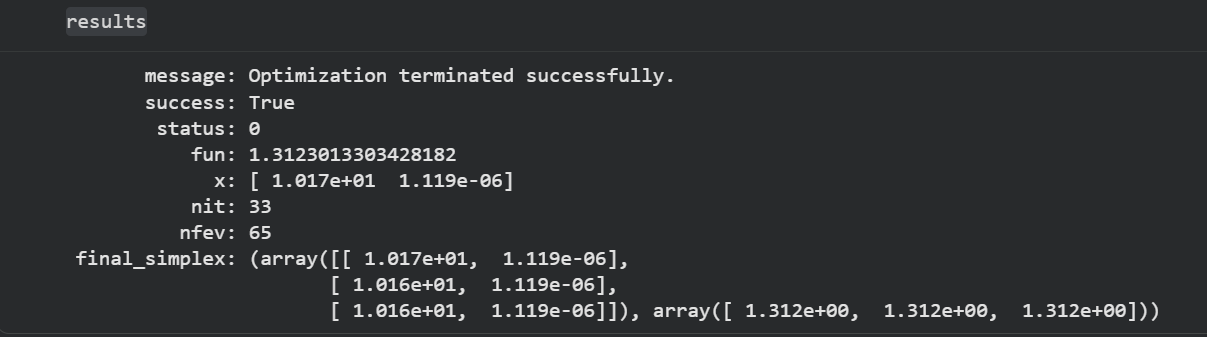

In [ ]:
from IPython.display import Image, display
display(Image("results.png", width=800))

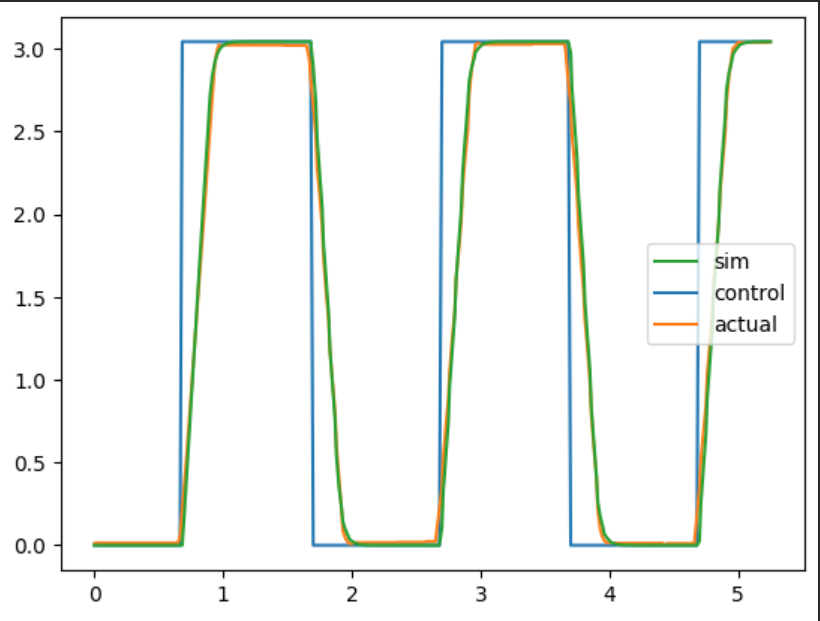

In [ ]:
from IPython.display import Image, display
display(Image("resultsplot.png", width=400))

The optimization algorithm (Nelder-Mead) terminated successfully after 33 iterations (nit: 33), confirming that a minimum error solution was found. The final cost function value (fun) was 1.312, representing the minimized sum of squared errors between the model and the experiment. The algorithm converged on the optimal parameter vector x:Parameter 1: 10.17 (likely Resistance $R$ or Torque Constant $k_t$ scaled up, depending on your code).Parameter 2: $1.12 \times 10^{-6}$ (likely Damping $b$), indicating that the optimized model assumes nearly zero viscous friction.

The optimization routine converged successfully, reducing the residual error to 1.31. The resulting parameters identified a significantly higher electrical resistance ($10.17 \Omega$) and negligible mechanical damping ($b \approx 10^{-6}$), suggesting the motor's dynamics are dominated by electrical constraints rather than mechanical friction.

 **6.2.5 What are the limits of your model, within which you are conȴdent of a good fit? Do you expect
your system to operate outside of those limits?**


Limits of the Model: The model is most accurate during continuous motion where viscous damping ($b\omega$) dominates. It loses confidence at near-zero velocities or during direction reversals because it ignores static friction (stiction) and gear backlash, which introduce non-linear 'stick-slip' behaviors that the simple linear model cannot predict. Additionally, the model assumes a constant 5V supply and ignores electrical inductance ($L$), meaning it creates a 'perfect' response that fails to account for battery voltage sag under heavy load or delays during extremely high-frequency control signals.

Operation Outside Limits: Yes, the system is expected to operate outside these limits, particularly during 'holding' tasks (where stiction helps maintain position without power) or during rapid aggressive maneuvering where voltage drops and inductive spikes would significantly alter the motor's true response compared to the simulation